In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import gpplot as gpp
import shap
gpp.set_aesthetics(context='paper')

In [2]:
def load_hyperparams(filename):
    hyperparams = {}
    with open(filename, 'r') as f:
        for line in f:
            key, value = line.strip().split(': ')
            try:
                value = float(value) if '.' in value else int(value)
            except ValueError:
                pass  
            hyperparams[key] = value
    return hyperparams

In [3]:
best_hyperparams = load_hyperparams('../../Data/modelTraining/best_hyperparams_full_featured.txt')
best_hyperparams

{'lambda': 0.00461089989462071,
 'alpha': 2.339185431719978,
 'subsample': 0.8843557017194346,
 'colsample_bytree': 0.7795190399711517,
 'max_depth': 5,
 'learning_rate': 0.008204611244539674,
 'n_estimators': 766}

In [4]:
#load and format training data
modelTrainingPath = "../../Data/modelTraining/"
train_df = pd.read_csv(f'{modelTrainingPath}trainData.csv')
X = train_df.drop(columns=['doubleZscore', 'Target_Gene_Symbol','sgRNA_Context_Sequence']).copy()
y = train_df['doubleZscore']

# train the final model on the full train dataset
final_model = xgb.XGBRegressor(**best_hyperparams)
final_model.fit(X, y)

# save this model (it uses one hot coding)
final_model.save_model(f'{modelTrainingPath}full_featured_model.json')

In [5]:
#load and format testing data
test_df = pd.read_csv(f'{modelTrainingPath}testData.csv')
Xtest = test_df.drop(columns=['doubleZscore', 'Target_Gene_Symbol','sgRNA_Context_Sequence']).copy()
ytest = test_df['doubleZscore']

#apply model to test dataset
predictions_test = final_model.predict(Xtest)
rmse_test = mean_squared_error(ytest, predictions_test, squared=False)
print(f"RMSE on the testing data: {rmse_test:.4f}")

RMSE on the testing data: 0.8284


In [6]:
test_df['yPred'] = final_model.predict(Xtest)

In [7]:
test_df

,Target_Gene_Symbol,sgRNA_Context_Sequence,ATAC_overlap_with_peak_proportion,DHS_overlap_with_peak_proportion,H3K4me3,H3k27ac,sgRNA_'Cut'_Site_TSS_Offset,doubleZscore,rs3ChenSeqScore,Domain_Kox1,...,TSS_Bucket__-5kb_to_5kb___775__800_,TSS_Bucket__-5kb_to_5kb___800__825_,TSS_Bucket__-5kb_to_5kb___825__850_,TSS_Bucket__-5kb_to_5kb___850__875_,TSS_Bucket__-5kb_to_5kb___875__900_,TSS_Bucket__-5kb_to_5kb___900__925_,TSS_Bucket__-5kb_to_5kb___925__950_,TSS_Bucket__-5kb_to_5kb___950__975_,TSS_Bucket__-5kb_to_5kb___975__1000_,yPred
0,ATIC,AAAACAACAAACAAAAAGGGAGGATGGTAG,0.285714,0.0,1.000000,1.000000,-412.0,-0.154541,-0.385688,1,...,0,0,0,0,0,0,0,0,0,-0.453620
1,ATIC,AAAACAACAAACAAAAAGGGAGGATGGTAG,0.285714,0.0,1.000000,1.000000,-412.0,-0.150163,-0.385688,0,...,0,0,0,0,0,0,0,0,0,-0.480634
2,ATIC,AAAATTAGACGGGTGTGGAGGCAGAGGCAG,0.142857,0.0,0.666667,1.000000,-923.0,-0.209122,0.136541,1,...,0,0,0,0,0,0,0,0,0,-0.503974
3,ATIC,AAAATTAGACGGGTGTGGAGGCAGAGGCAG,0.142857,0.0,0.666667,1.000000,-923.0,-0.190126,0.136541,0,...,0,0,0,0,0,0,0,0,0,-0.575912
4,ATIC,AAACAAAAGGAATAGTTCATATAGCGGCAA,0.428571,0.0,1.000000,1.000000,-369.0,0.520852,0.873762,1,...,0,0,0,0,0,0,0,0,0,-0.369707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32829,ZNHIT6,TTTAATGGTTAACACAGATTAGGGTGGGTT,1.000000,0.0,1.000000,1.000000,-293.0,-0.458460,0.611774,1,...,0,0,0,0,0,0,0,0,0,-0.150962
32830,ZNHIT6,TTTACGGCTCTGCGGAGGCCCTGCCGGATT,1.000000,1.0,1.000000,1.000000,-80.0,-0.478862,-0.431003,1,...,0,0,0,0,0,0,0,0,0,-0.187760
32831,ZNHIT6,TTTAGTGGTAAAAGAAGCGAAGGTGGGTGA,0.857143,0.0,1.000000,1.000000,541.0,-0.386223,0.557163,1,...,0,0,0,0,0,0,0,0,0,0.191068
32832,ZNHIT6,TTTCTGGAGTCAGACGGCGTTCGCGGGGGT,0.142857,0.0,1.000000,0.666667,943.0,-0.296669,-0.492183,1,...,0,0,0,0,0,0,1,0,0,-0.459560


In [8]:
def calculate_spearman_within_groups(df):
    spearman_corrs = []
    groups = df['Target_Gene_Symbol'].unique()
    
    for group in groups:
        group_data = df[df['Target_Gene_Symbol'] == group]
        yPred_corr, _ = spearmanr(group_data['doubleZscore'], group_data['yPred'])
        RS3_corr, _ = spearmanr(group_data['doubleZscore'], group_data['rs3ChenSeqScore'])
        spearman_corrs.append({'Target_Gene_Symbol': group, 'spearman_corr_crispri_model': yPred_corr, 'spearman_corr_RS3seq': RS3_corr})
    
    return pd.DataFrame(spearman_corrs)

spearman_df = calculate_spearman_within_groups(test_df)

{'whiskers': [<matplotlib.lines.Line2D at 0x30b20fe80>,
 'caps': [<matplotlib.lines.Line2D at 0x30b22e400>,
 'boxes': [<matplotlib.lines.Line2D at 0x30b20fd00>,
 'medians': [<matplotlib.lines.Line2D at 0x30b22e940>,
 'fliers': [<matplotlib.lines.Line2D at 0x30b22ebe0>,
 'means': []}

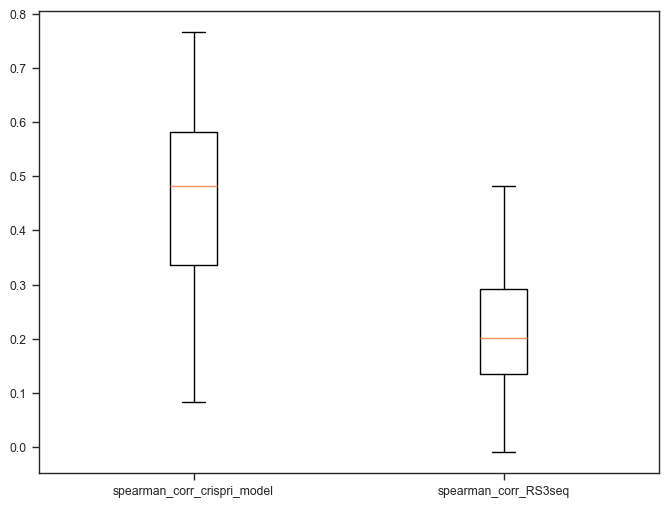

In [9]:
# Plot the boxplot of Spearman correlations
plt.figure(figsize=(8, 6))
plt.boxplot(spearman_df[['spearman_corr_crispri_model', 'spearman_corr_RS3seq']], 
            labels=['spearman_corr_crispri_model', 'spearman_corr_RS3seq'])

### Analyze feature contribution with SHAP values

In [10]:
explainer = shap.TreeExplainer(final_model)

In [11]:
shap_values = explainer(Xtest)

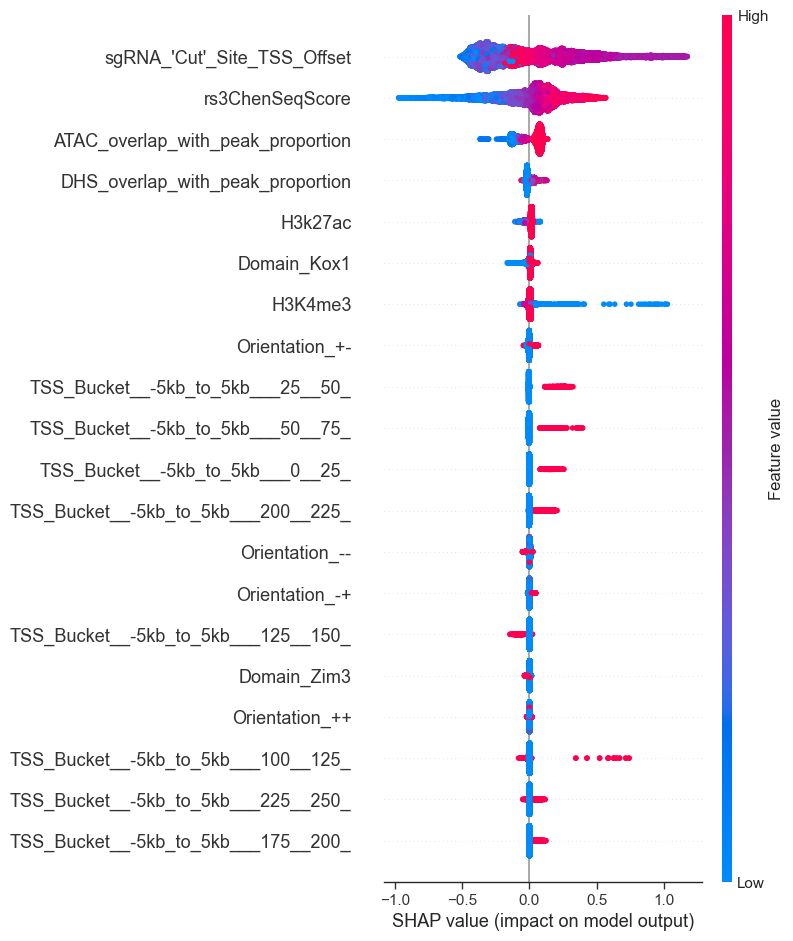

In [12]:
shap.summary_plot(shap_values, Xtest)

In [13]:
Xtest_renamed = Xtest.copy()
Xtest_renamed.columns = ['ATAC overlap with peak proportion', 'DHS overlap with peak proportion',
                         'H3K4me3 overlap with peak proportion', 'H3k27ac overlap with peak proportion',
                         'sgRNA \'Cut\' Site TSS Offset', 'RS3 Sequence Score (with Chen tracrRNA)',
                         'Kox1 Domain', 'Zim3 Domain', '++ Orientation', '+- Orientation'] + Xtest.columns[10:].tolist()
Xtest_renamed
shap_values = explainer(Xtest_renamed)
Xtest_renamed.iloc[:,:10]

,ATAC overlap with peak proportion,DHS overlap with peak proportion,H3K4me3 overlap with peak proportion,H3k27ac overlap with peak proportion,sgRNA 'Cut' Site TSS Offset,RS3 Sequence Score (with Chen tracrRNA),Kox1 Domain,Zim3 Domain,++ Orientation,+- Orientation
0,0.285714,0.0,1.000000,1.000000,-412.0,-0.385688,1,0,1,0
1,0.285714,0.0,1.000000,1.000000,-412.0,-0.385688,0,1,1,0
2,0.142857,0.0,0.666667,1.000000,-923.0,0.136541,1,0,1,0
3,0.142857,0.0,0.666667,1.000000,-923.0,0.136541,0,1,1,0
4,0.428571,0.0,1.000000,1.000000,-369.0,0.873762,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
32829,1.000000,0.0,1.000000,1.000000,-293.0,0.611774,1,0,0,0
32830,1.000000,1.0,1.000000,1.000000,-80.0,-0.431003,1,0,0,0
32831,0.857143,0.0,1.000000,1.000000,541.0,0.557163,1,0,0,0
32832,0.142857,0.0,1.000000,0.666667,943.0,-0.492183,1,0,0,0


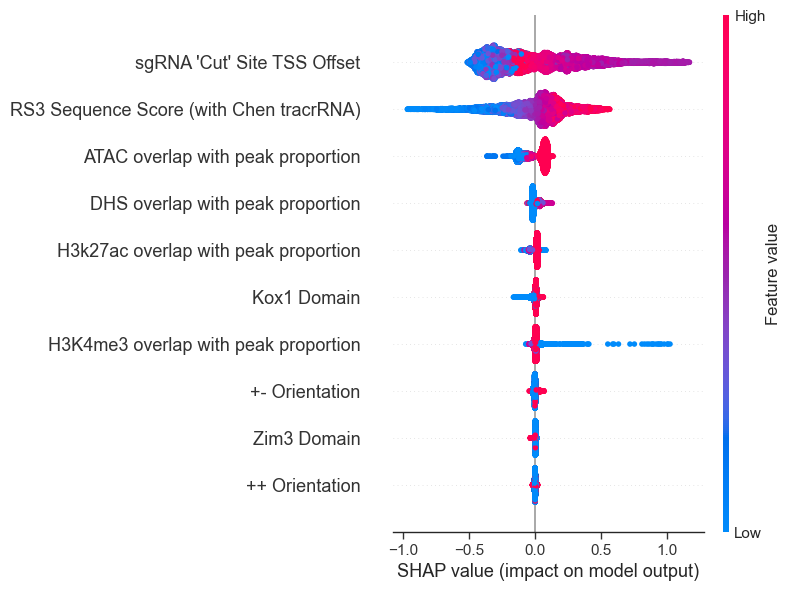

In [14]:
shap.summary_plot(shap_values[:, :10], Xtest_renamed.iloc[:,:10], plot_size=(8, 6), show=False)
gpp.savefig('../../Figures/Figure 4/shap_summary_top10_features.pdf', dpi = 300, bbox_inches='tight')